# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M42_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## Event M42
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:20")
config['tend'] = obs.UTCDateTime("2022-12-31 12:12:55")

# config['fmin'] = 1
# config['fmax'] = 5.0

## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

## Eventtime
config['eventtime'] = event.origins[0].time

In [260]:
st0 = obs.read("./event42_6c.mseed")

st0.trim(st0[0].stats.starttime+5, st0[0].stats.endtime-15)

# for tr in st0:
#     if "BSPF" in tr.stats.station:
#         tr.data = np.roll(tr.data, 3)

submask = "al"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

In [261]:
# ##load rotation
# bspf0, bspf_inv = __request_data("PY.BSPF..HJ*", config['tbeg'], config['tend'])
# bspf0.resample(40);

# ## load translation
# pfo0, pfo_inv = __request_data("II.PFO.10.BH*", config['tbeg'], config['tend'], translation_type="ACC")

# # merge to one stream
# st0 = bspf0.copy();
# st0 += pfo0.copy();

# ## ADR
# submask = "inner"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "in"
# st0 += adr0.copy();

# submask = "mid"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "mi"
# st0 += adr0.copy();

# # submask = "all"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "al"
# st0 += adr0.copy();


# st0.trim(config['tbeg']+1, config['tend']-1)

# st0.write("./event42_6c.mseed", format="MSEED")

# # st0.plot(equal_scale=False);

In [262]:
# st0.plot(equal_scale=False);

## Create stream for all data

In [263]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    from obspy.signal.cross_correlation import correlate

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    lw = 1.2
    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z", color="k", lw=lw)
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z", color="r", lw=lw)

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N", color="k", lw=lw)
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N", color="r", lw=lw)

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E", color="k", lw=lw)
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E", color="r", lw=lw)

    cc_Z = round(correlate(bspf.select(channel="*Z")[0].data, adr.select(channel="*Z")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc_N = round(correlate(bspf.select(channel="*N")[0].data, adr.select(channel="*N")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc_E = round(correlate(bspf.select(channel="*E")[0].data, adr.select(channel="*E")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("$\Omega$ (rad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

HJE 1.0636981698373193e-07
HJN 4.525757498852491e-08
HJZ 3.11347632862209e-08


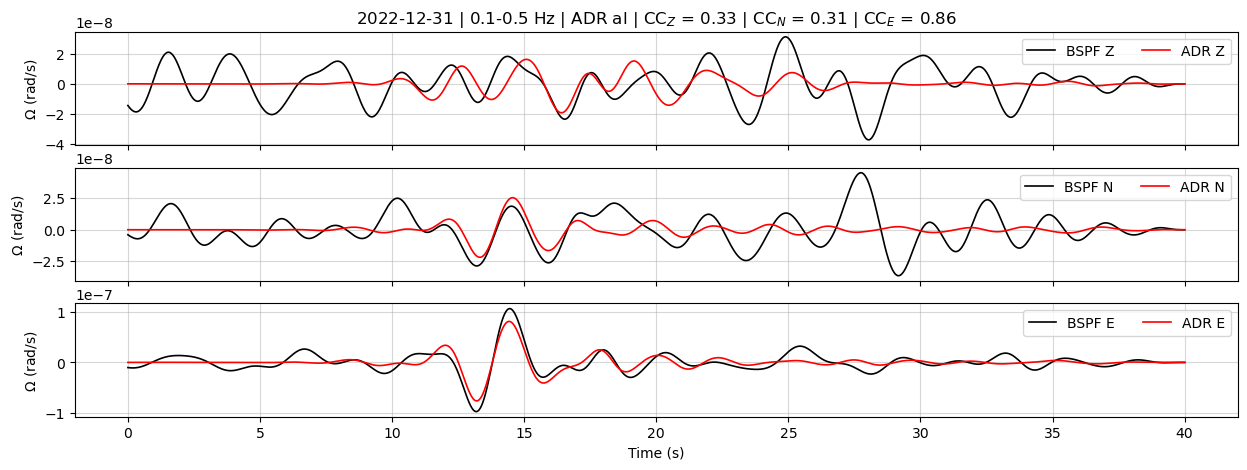

In [264]:
if submask == "in":
    config['fmin'], config['fmax'] = 1.0, 6.0
elif submask == "mi":
    config['fmin'], config['fmax'] = 0.5, 1.0
elif submask == "al":
    config['fmin'], config['fmax'] = 0.1, 0.5


bspf = bspf0.copy()
bspf = bspf.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

adr = adr0.copy()
adr = adr.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

pfo = pfo0.copy()
pfo = pfo.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

for tr in bspf:
    print(tr.stats.channel, max(tr.data))

fig = __makeplot_waveform_comparison(bspf, adr, submask)

fig.savefig(config['path_to_figs']+f"BSPF_M42_waveforms_{submask}.png", format="png", dpi=200, bbox_inches='tight');

In [107]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

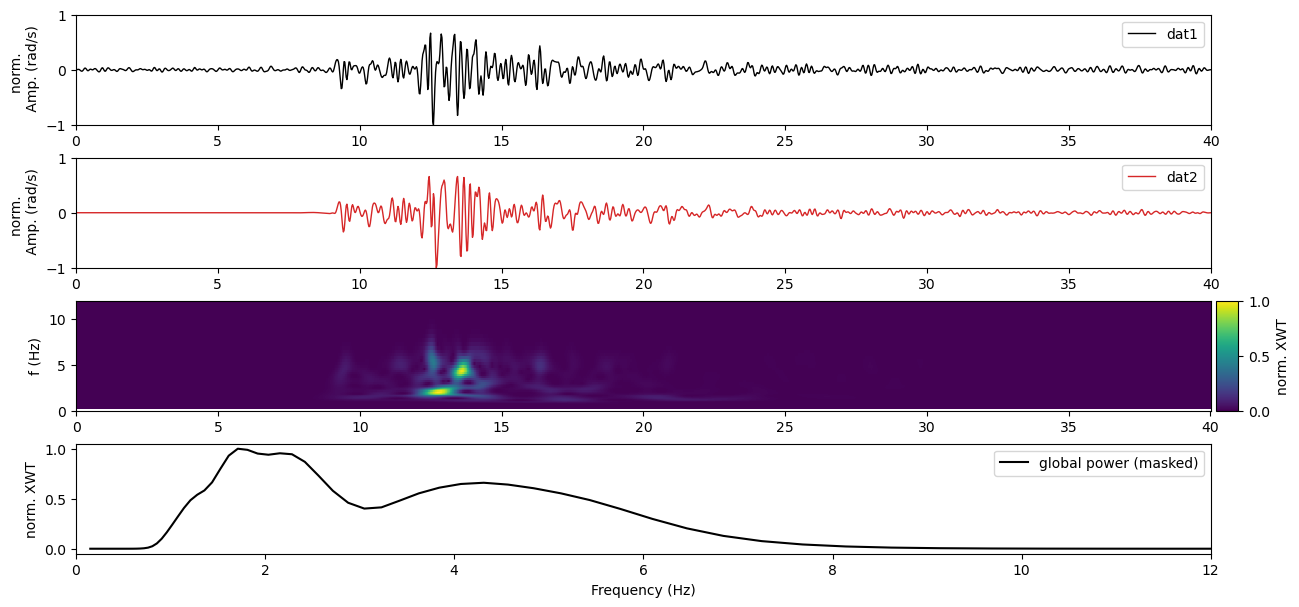

In [108]:
acc = st0.select(station="PFO*").copy().detrend("demean")
rot = st0.select(station="BSPF").copy().detrend("demean")
adr = st0.select(station="RPFO", location=submask).copy().detrend("demean")

rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
adr = adr.detrend("demean").taper(0.01).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)


comp = "E"

out = __compute_cross_wavelet_transform(
                                    rot[0].times(),
                                    rot.select(channel=f"*{comp}")[0].data,
                                    adr.select(channel=f"*{comp}")[0].data,
                                    rot[0].stats.delta,
                                    xwt_threshold=0.,
                                    fmax_limit=config['fmax'],
                                    normalize=True,
                                    plot=True,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_xwt_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [109]:
from obspy.signal.cross_correlation import correlate

In [110]:
correlate(rot.select(channel=f"*{comp}")[0].data, adr.select(channel=f"*{comp}")[0].data, 0)

array([-0.22682223])

In [111]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

In [112]:
# out_wct = __compute_wavelet_coherency_transform(
#                                             rot[0].times(),
#                                             rot.select(channel=f"*{comp}")[0].data,
#                                             adr.select(channel=f"*{comp}")[0].data,
#                                             rot[0].stats.delta,
#                                             fmax_limit=config['fmax'],
#                                             normalize=True,
#                                             plot=True,
# )

# out_wct['fig'].savefig(config['path_to_figs']+f"BSPF_M42_wct_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## Coherence in Octaves

In [113]:
from functions.makeplot_coherence_octaves import __coherence_in_octaves

In [114]:
def __coherence_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax, nanmean
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=8, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter]

    out = {}

    if plot:
        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)

        if normalize:
            tr0 = tr0.normalize()
            tr1 = tr1.normalize()
            tr2 = tr2.normalize()
            tr3 = tr3.normalize()
            rot_scale, rot_unit = 1, r"rad/s"

        co2, co3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            df = s1.stats.sampling_rate

            # tseg = 5/fl
            tseg = 20
            nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
            nover = int(0.5*nseg)

            ff2, coh2 = coherence(s0.data, s2.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)

#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')

            for i in range(len(ff2)):
                if ff2[i] <= fl or ff2[i] >= fu:
                    coh2[i], coh3[i] = nan, nan

            plt.semilogx(ff2, coh2)

            # co2.append(nanmax(coh2))
            # co3.append(nanmax(coh3))
            co2.append(nanmean(coh2))
            co3.append(nanmean(coh3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, co2, s=40, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, co3, s=40, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co3, ls=":", color=colors[comp])

            ax7.legend(loc=4, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)



        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_co']  = co2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_co']  = co3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

/tmp/ipykernel_390196/2627792359.py:96: RuntimeWarning: Mean of empty slice
  co2.append(nanmean(coh2))
/tmp/ipykernel_390196/2627792359.py:97: RuntimeWarning: Mean of empty slice
  co3.append(nanmean(coh3))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No arti

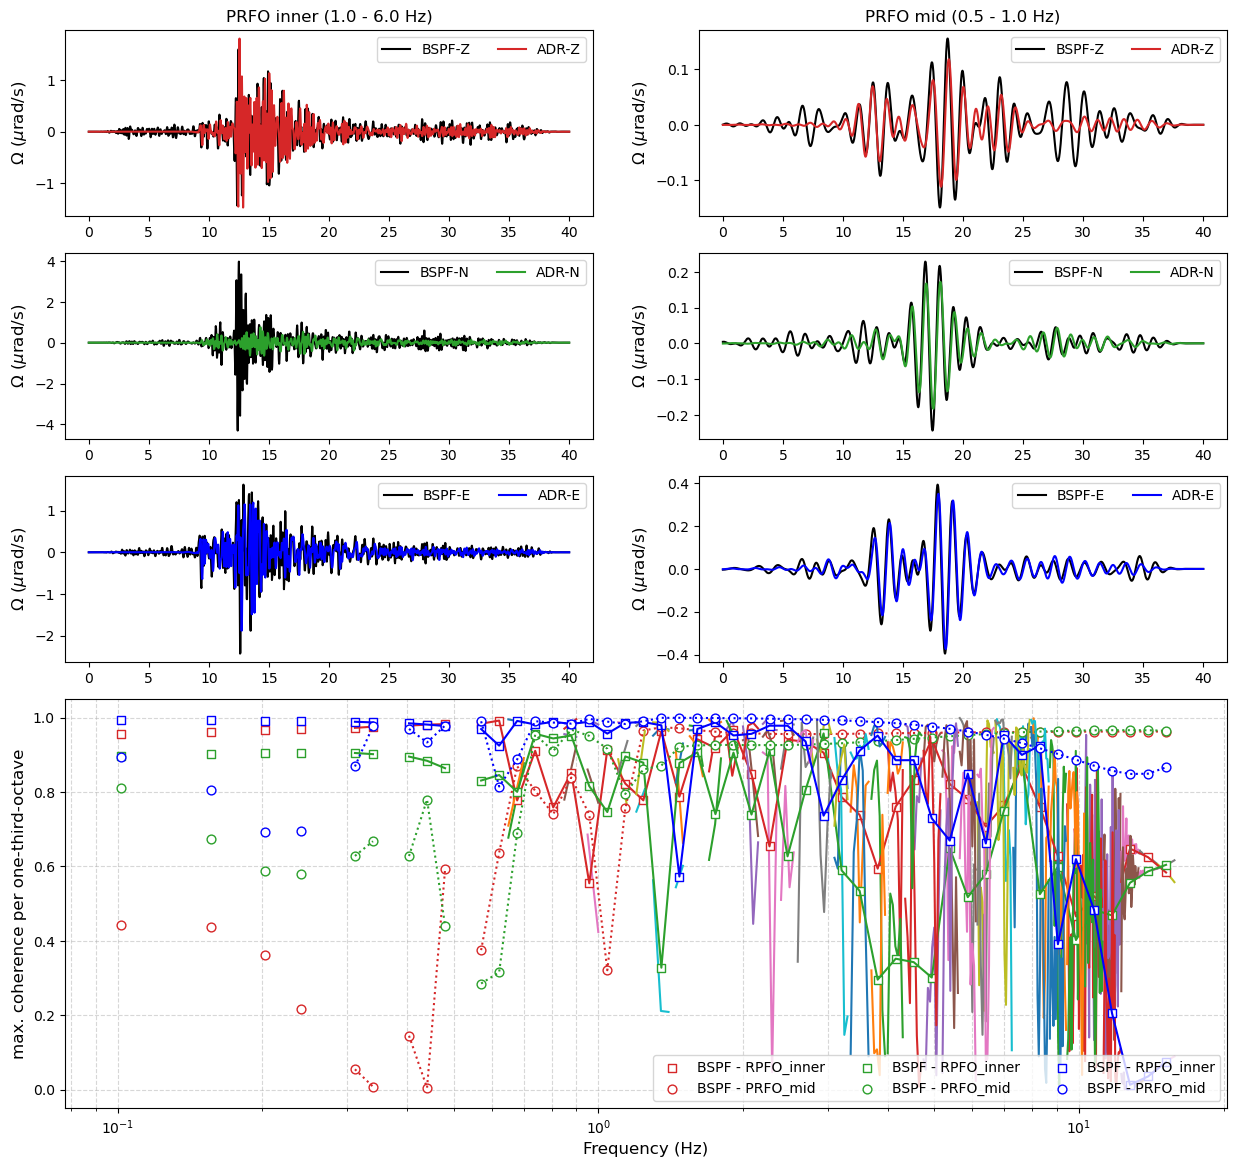

In [115]:
st = st0.copy();

fmin, fmax = 0.1, 15.0

st.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

out_coh = __coherence_in_octaves(st, fmin, fmax, normalize=False, plot=True)

out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_coherence.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

In [116]:
def __crosscorrelation_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from obspy.signal.cross_correlation import correlate

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=6, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

    out = {}

    if plot:

        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)


        cc2, cc3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            s0 = s0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s1 = s1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s2 = s2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s3 = s3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)

            _cc2 = correlate(s0.data, s2.data, 0, demean=True, normalize='naive', method='fft')
            _cc3 = correlate(s1.data, s3.data, 0, demean=True, normalize='naive', method='fft')

            cc2.append(nanmax(_cc2))
            cc3.append(nanmax(_cc3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, cc2, s=20, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, cc3, s=20, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc3, ls=":", color=colors[comp])

            ax7.legend(loc=3, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)

            ax7.set_ylim(-1, 1)


        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_cc']  = cc2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_cc']  = cc3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


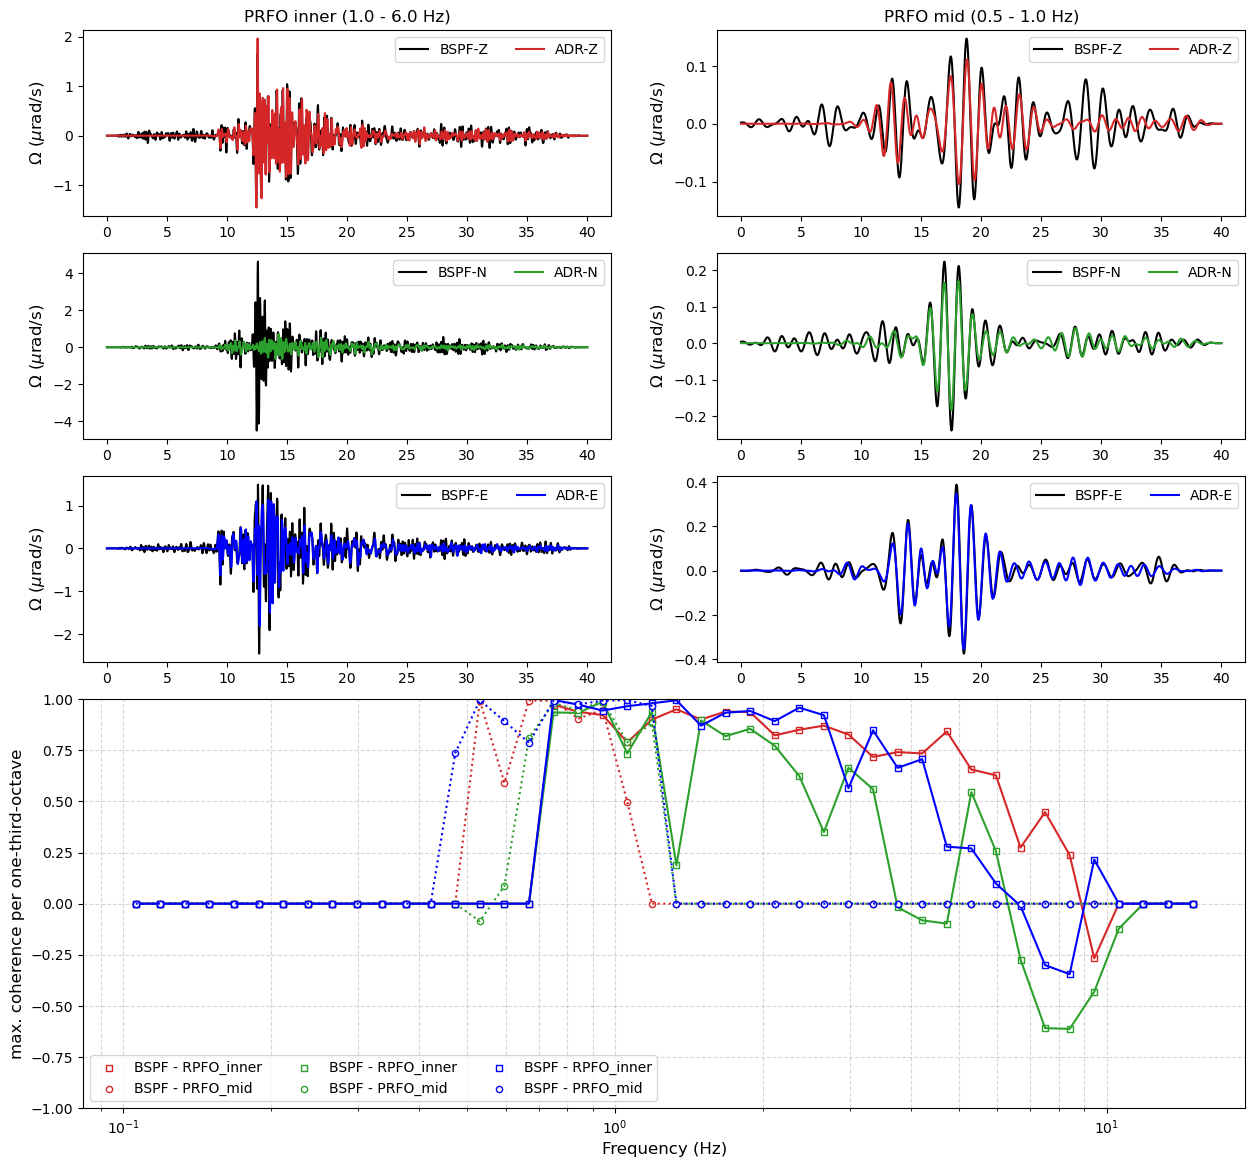

In [246]:
st = st0.copy();

for tr in st:
    if "BSPF" in tr.stats.station:
        tr.data = np.roll(tr.data, 3)


fmin, fmax = 0.1, 15.0

st.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

out_coh = __crosscorrelation_in_octaves(st, fmin, fmax, normalize=False, plot=True)

out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_crosscorrelation_octaves.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Backazimuth

In [119]:
from functions.compute_backazimuth import __compute_backazimuth

In [130]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = config['fmin'], config['fmax']
print(fmin, fmax)

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)


# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

1.0 6.0


3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples
II.PFO.10.BHN | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples
II.PFO.10.BHZ | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples

In [121]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

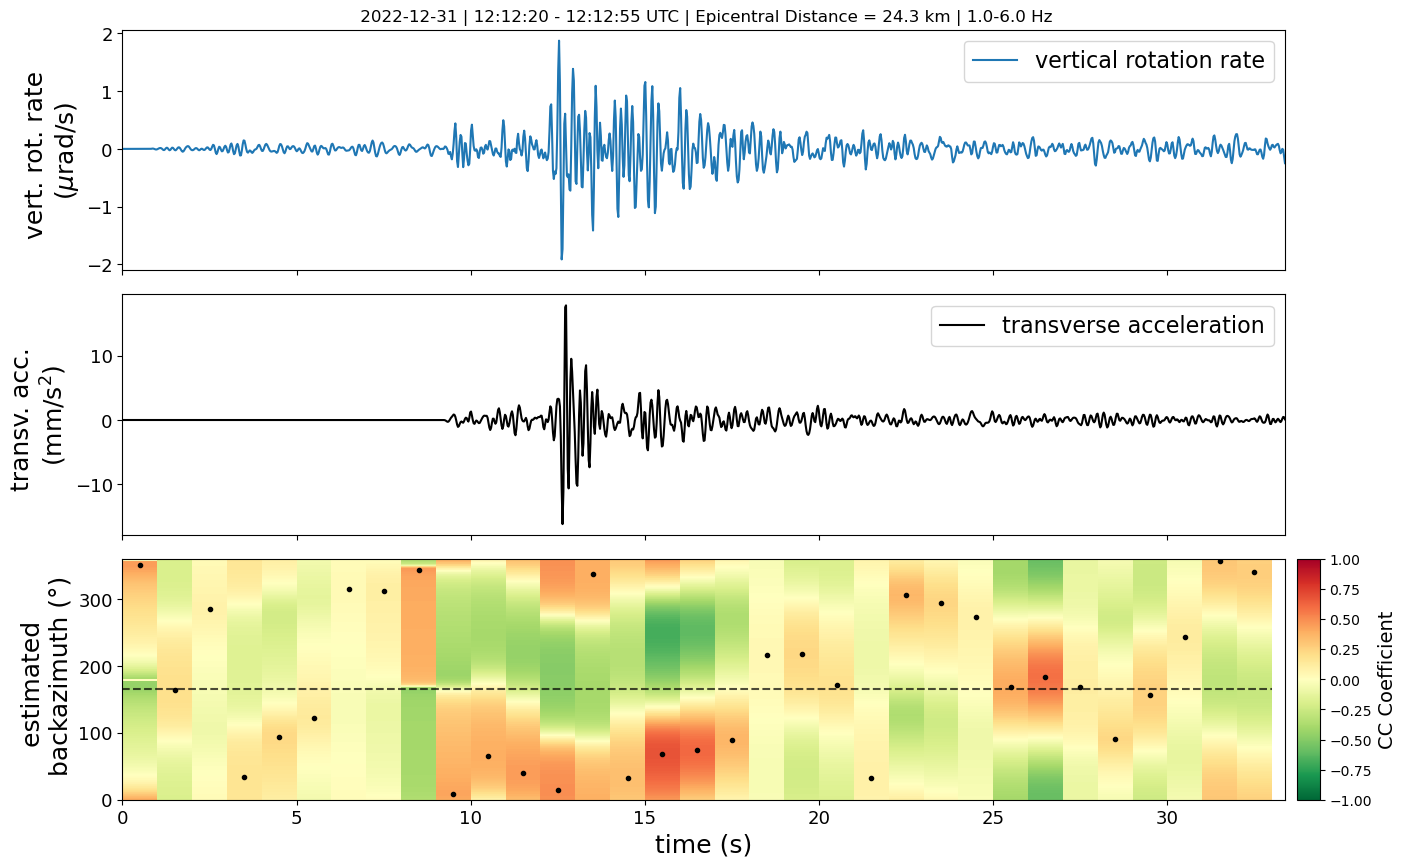

In [122]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


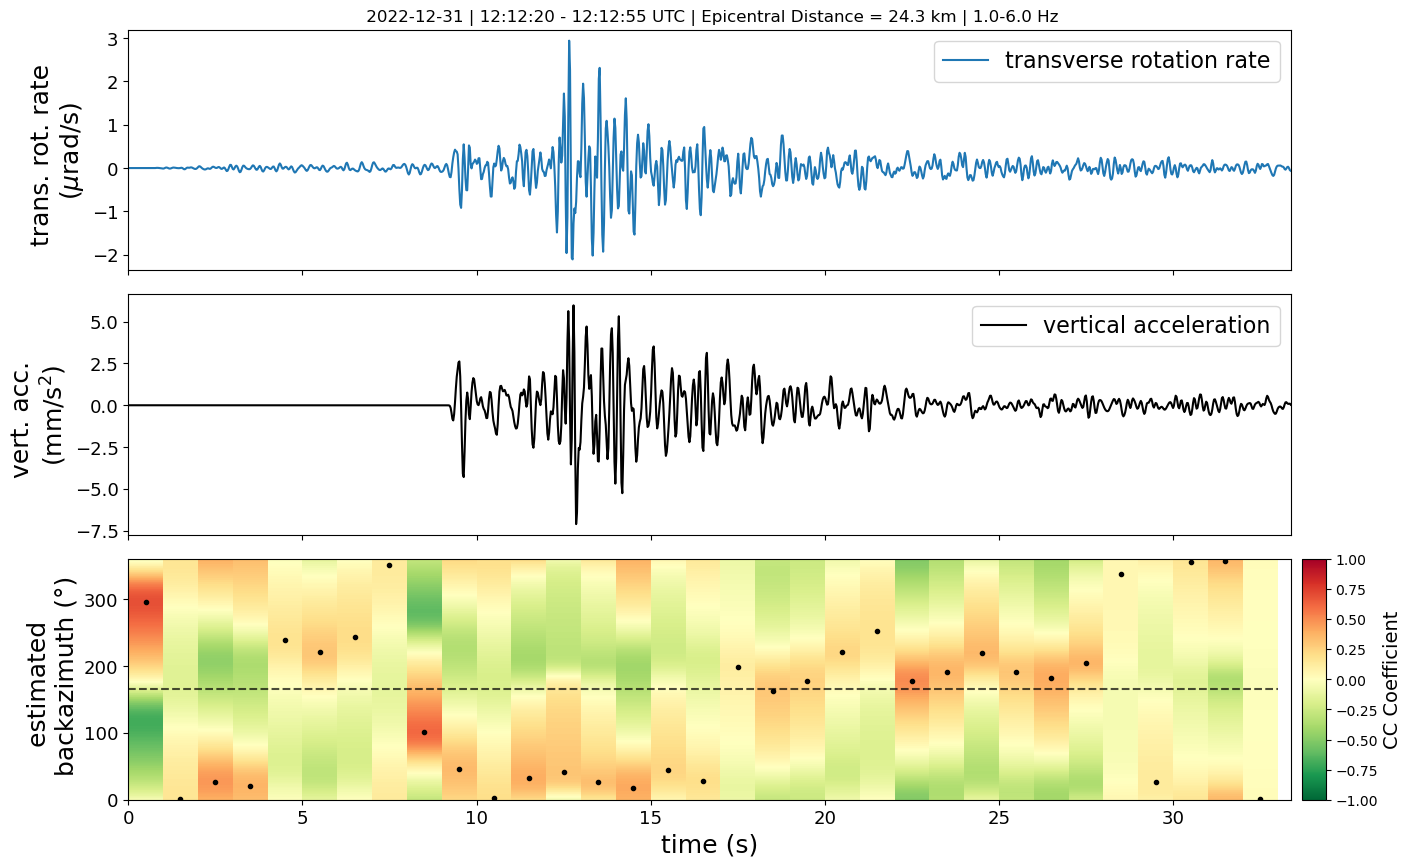

In [123]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [124]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [125]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

In [126]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [128]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()
rot = st0.select(station="RPFO", location="mi").copy()

fmin, fmax = 0.8, 2.0
# fmin, fmax = config['fmin'], config['fmax']


rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# for tr in rot:
#     tr.data = np.roll(tr.data, -10)

# for tr in acc:
#     if "*Z" in tr.stats.channel:
#         tr.data *= -1

# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples
II.PFO.10.BHN | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples
II.PFO.10.BHZ | 2022-12-31T12:12:21.644538Z - 2022-12-31T12:13:01.644538Z | 40.0 Hz, 1601 samples

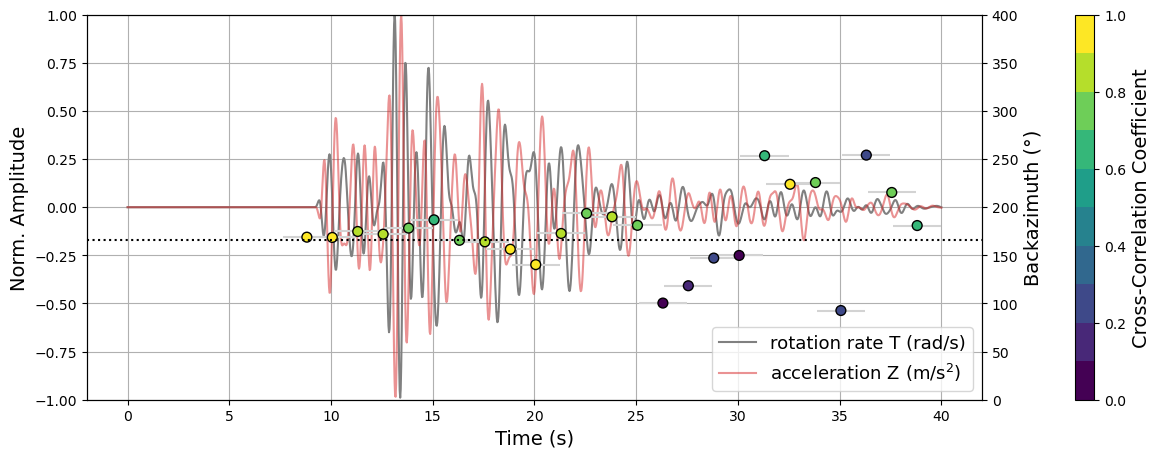

In [129]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=1/fmin,
                                    overlap=0.9,
                                    baz_theo=baz,
                                    cc_thres=0,
                                    plot=True,
                                    )

out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Compare Backazimuth Codes

In [131]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [237]:
def __compare_backazimuth_codes(rot0, acc0, cat_event, fmin, fmax, cc_thres=None, plot=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange
    from obspy import UTCDateTime    
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    rot = rot0.copy()
    acc = acc0.copy()

    rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = {}

    config['tbeg'] = rot[0].stats.starttime
    config['tend'] = rot[0].stats.endtime

    ## Eventtime
    config['eventtime'] = UTCDateTime(cat_event.origins[0].time)

    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = 1/fmin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = 90

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s= config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=0,
                                        plot=False,
    )

    ## filter according to cc-threshold
    if cc_thres:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= cc_thres:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= cc_thres:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= cc_thres:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    if plot:

        NN = 6
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        fig1, ax = plt.subplots(NN, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.2)

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, out3['baz_theo'])
        jr, jt = rotate_ne_rt(jn.data, je.data, out3['baz_theo'])

        ## reverse polarity of transverse rotation!!
        jt *= -1

        t1, t2 = hz.times().min(), hz.times().max()

        ax[0].plot(hz.times(), ht*trans_scaling, 'black', label=f"PFO.T")
        ax[1].plot(hz.times(), hr*trans_scaling, 'black', label=f"PFO.R")
        ax[2].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"PFO.Z")

        ax[0].set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax[1].set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax[2].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax[0].twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax[1].twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax22 = ax[2].twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax[3].set_ylabel(f"Rayleigh Baz.(°)")
        ax[4].set_ylabel(f"Love Baz.(°)")
        ax[5].set_ylabel(f"CoVar. Baz.(°)")


        ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

        ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

        ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

        for i in [0,1,2]:
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            ax[i].legend(loc=1)
            ax[i].set_ylabel(f"a ({trans_unit})")

        for i in [3,4,5]:
            ax[i].set_ylim(-5, 365)
            ax[i].set_yticks(range(0,360+60,60))
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            # ax[i].set_ylabel(f"Baz.(°)")
            ax[i].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            ax[i].fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax[5].set_xlabel("Time (s)")

        plt.show();



    ## compute statistics
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
    cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

    hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

    baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
    baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

    # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
    kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=baz_rayleigh_no_nan)
    baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]

    ## ______________________________________
    ## Love
    baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
    cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

    hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

    baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
    baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

    # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
    kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
    baz_love_max = angles2[argmax(kde2.pdf(angles2))]

    ## ______________________________________
    ## Tangent
    baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
    cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

    hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

    baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
    baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

    # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
    kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
    baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]

    if plot:

        fig2, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)
        ax[0].plot(angles, kde1.pdf(angles), c='C1', lw=2, label='KDE')
        ax[0].axvline(baz_rayleigh_max, color="r")
        ax[0].axvline(baz_rayleigh_mean, color="g")
        ax[0].set_title("Rayleigh")
        ax[0].set_xlabel("Backazimuth")
        ax[0].set_ylabel("Density")

        ax[1].hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)
        ax[1].plot(angles, kde2.pdf(angles), c='C1', lw=2, label='KDE')
        ax[1].axvline(baz_love_max, color="r")
        ax[1].axvline(baz_love_mean, color="g")
        ax[1].set_title("Love")
        ax[1].set_xlabel("Backazimuth")

        ax[2].hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)
        ax[2].plot(angles, kde3.pdf(angles), c='C1', lw=2, label='KDE')
        ax[2].axvline(baz_tangent_max, color="r")
        ax[2].axvline(baz_tangent_mean, color="g")
        ax[2].set_title("Co.Var.")
        ax[2].set_xlabel("Backazimuth")
        plt.show();


    ## prepare output directory
    out = {}
    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std


    if plot:
        out['fig1'] = fig1
        out['fig2'] = fig2

    return out

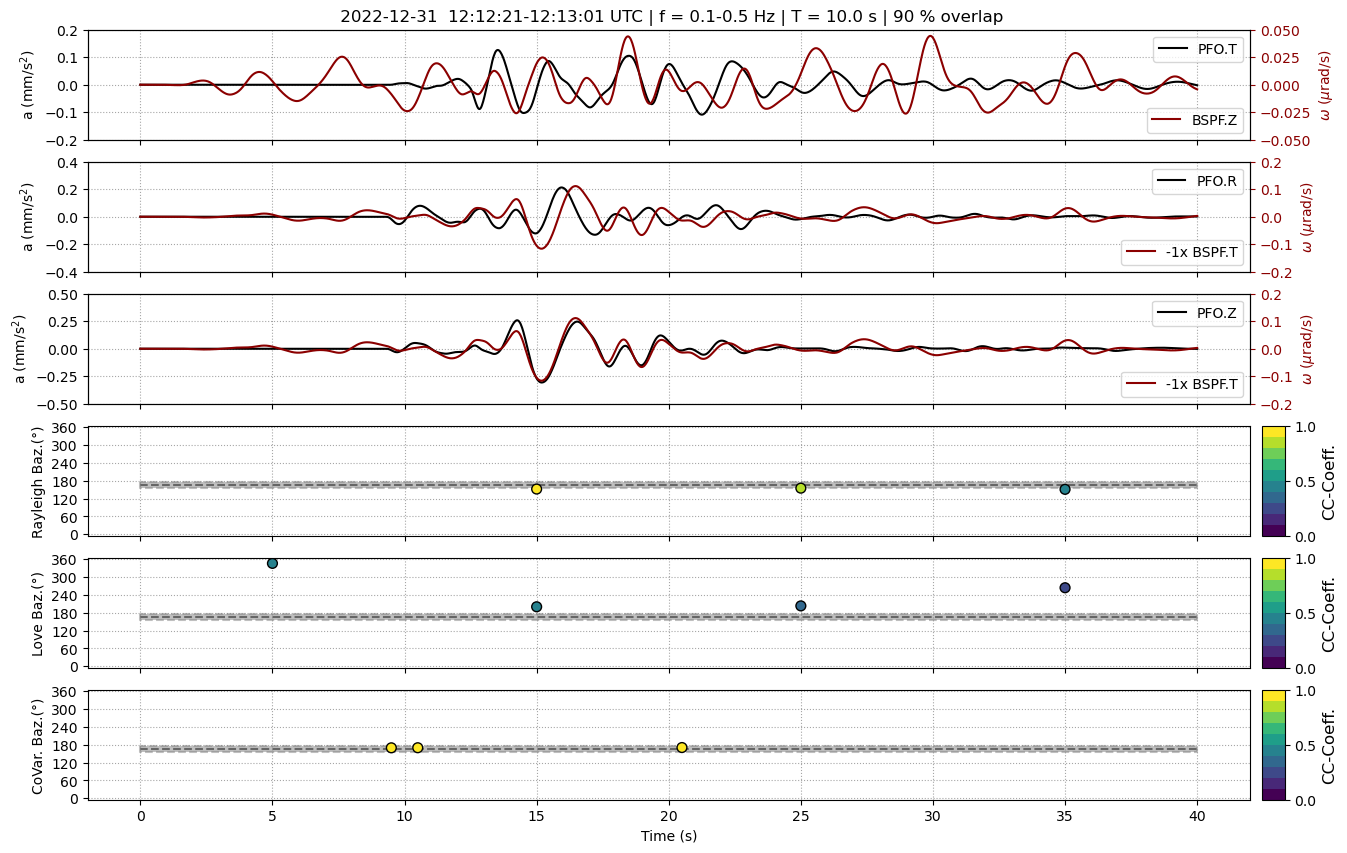

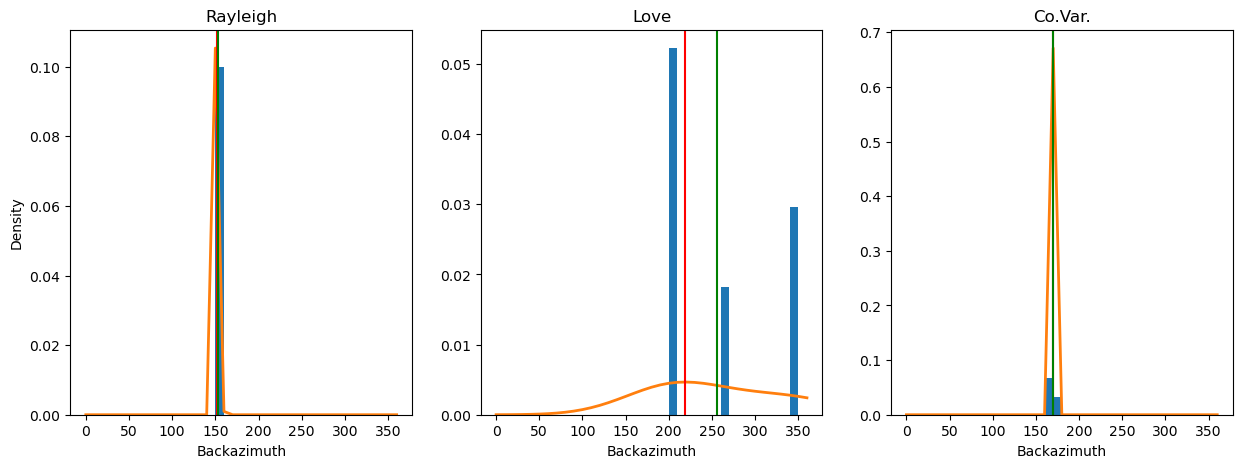

In [241]:
st = st0.copy();

acc = st.select(station="PFO*");
rot = st.select(station="BSPF");
# rot = st.select(station="RPFO", location="in");
# rot = st.select(station="RPFO", location="mi");
# rot = st.select(station="RPFO", location="al");

for tr in rot:
    tr.data = np.roll(tr.data, 3)


# fmin, fmax = config['fmin'], config['fmax']
fmin, fmax = 0.1, 0.5

out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);

out['fig1'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
out['fig2'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_his2.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [152]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

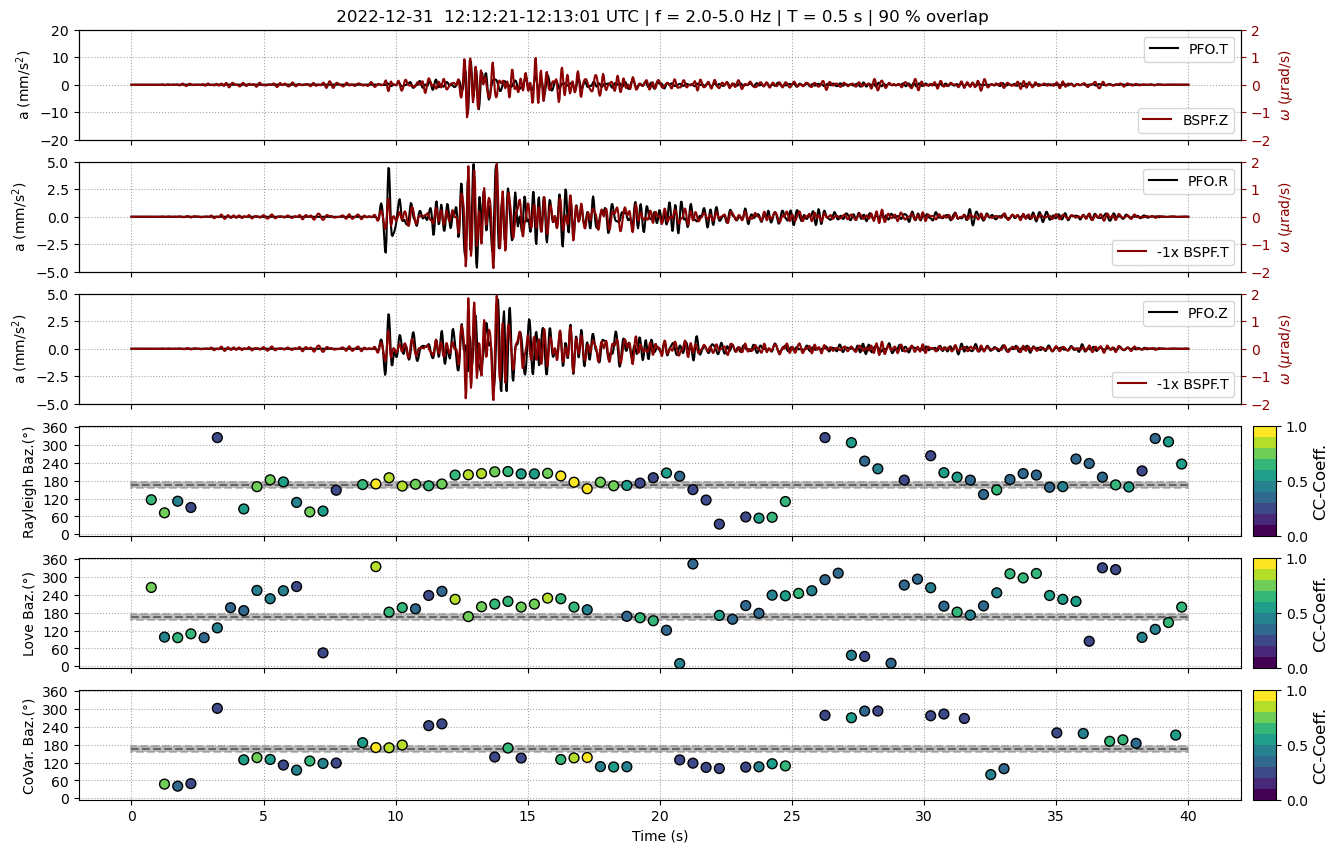

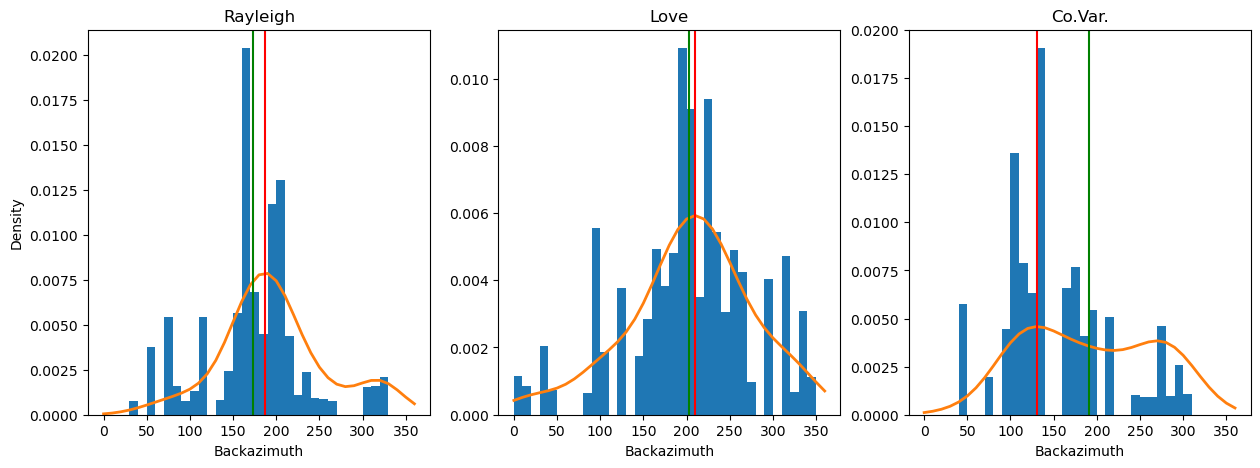

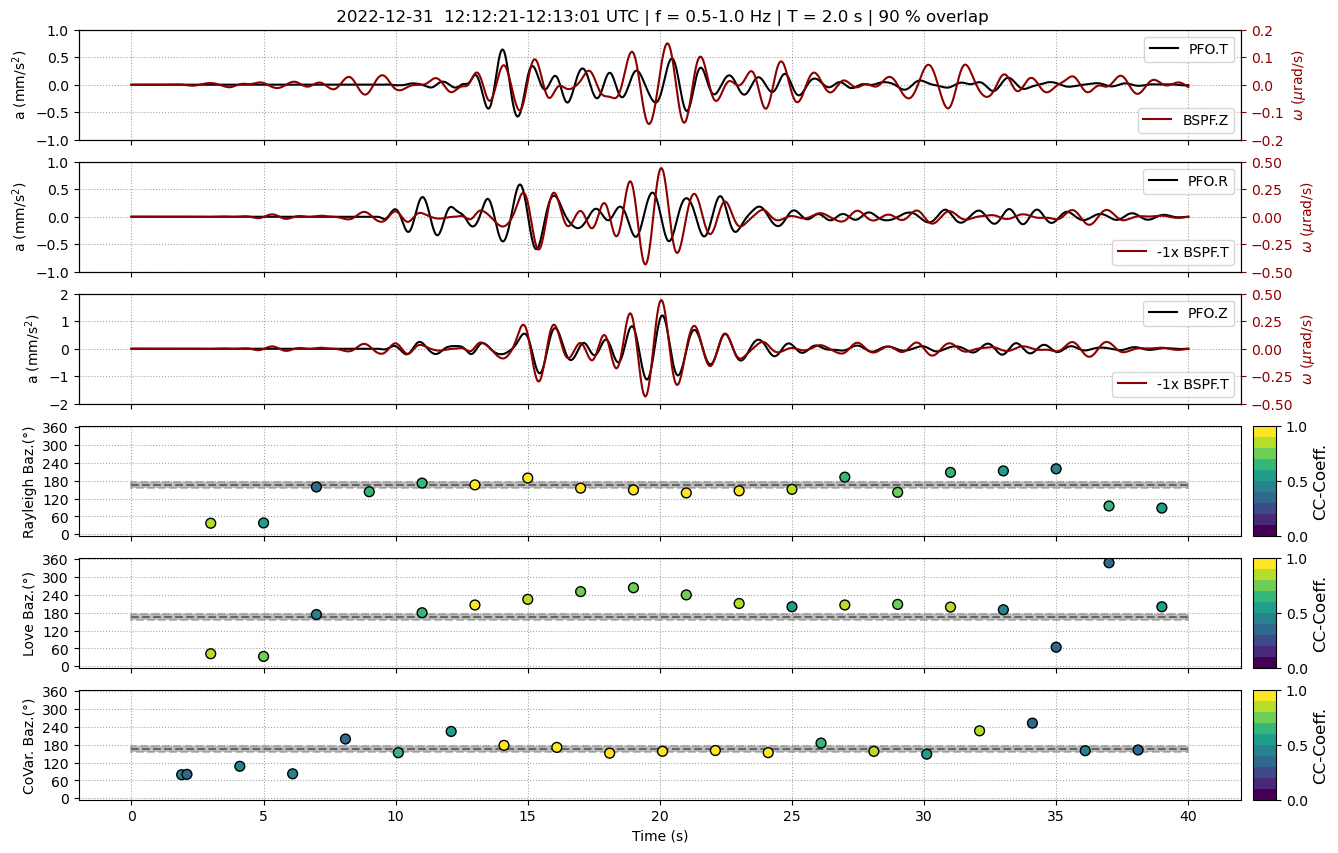

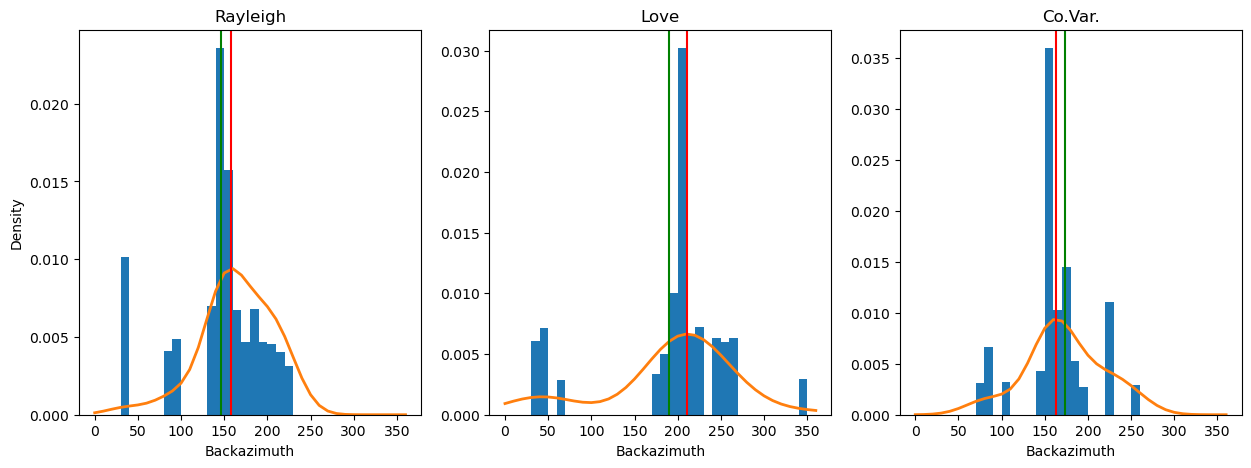

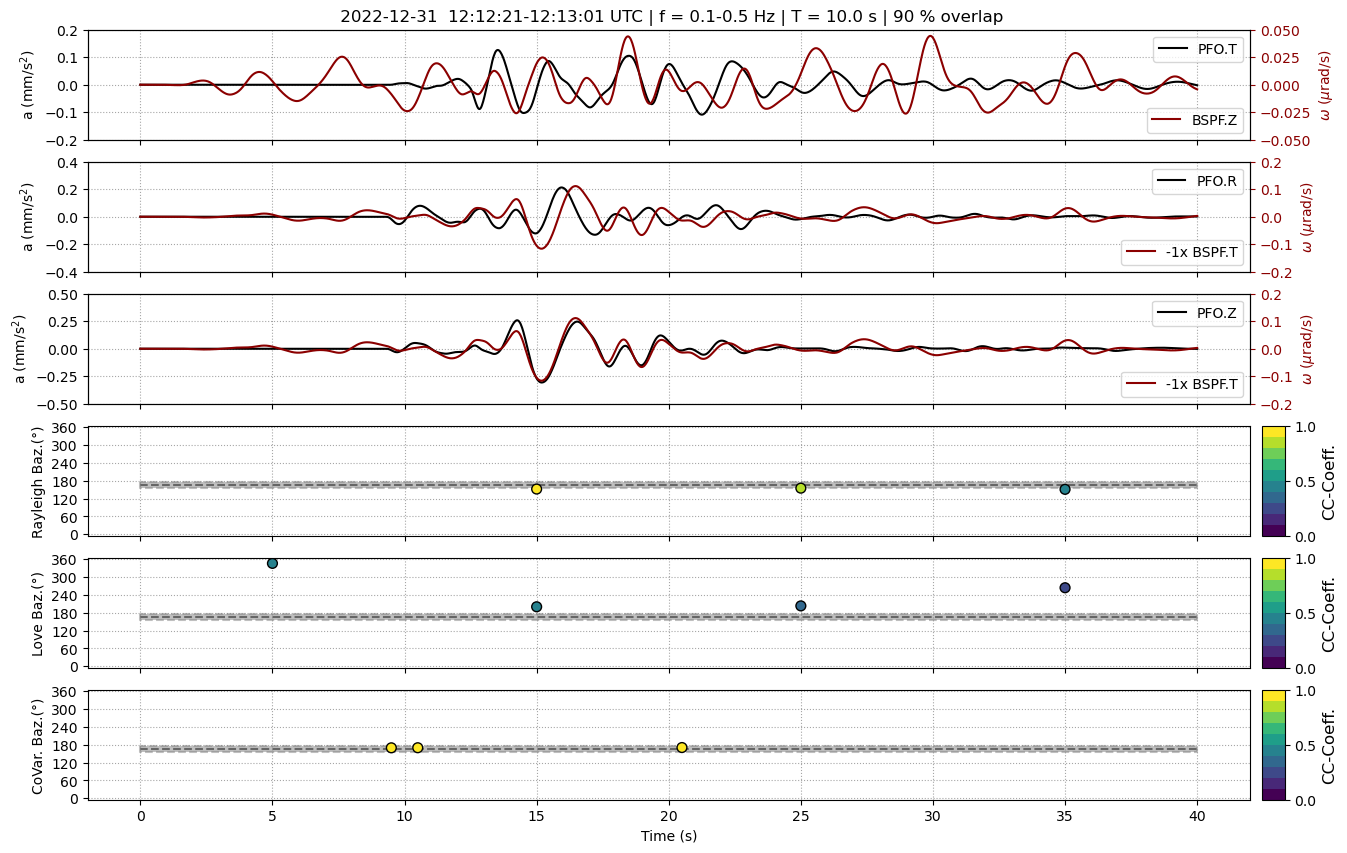

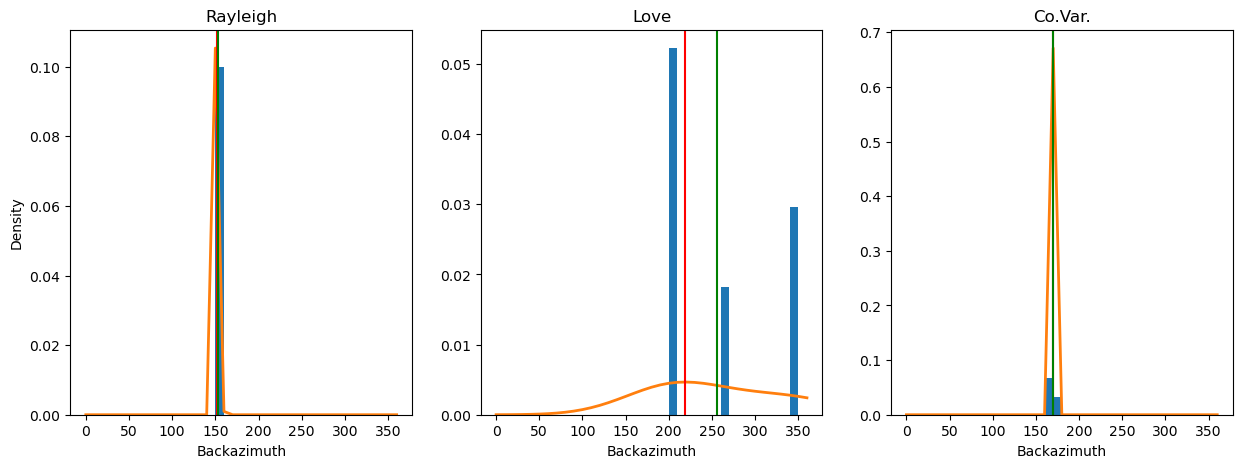

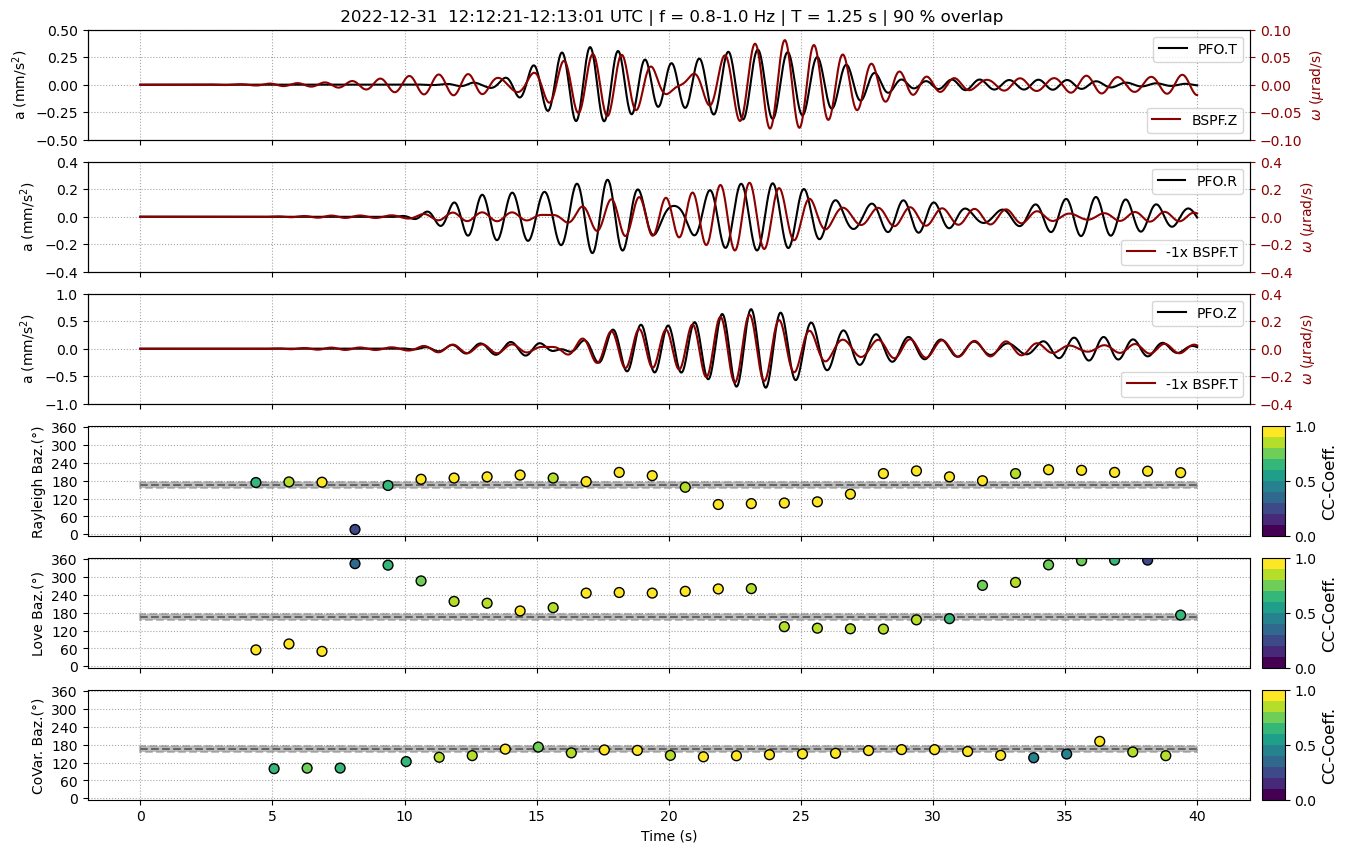

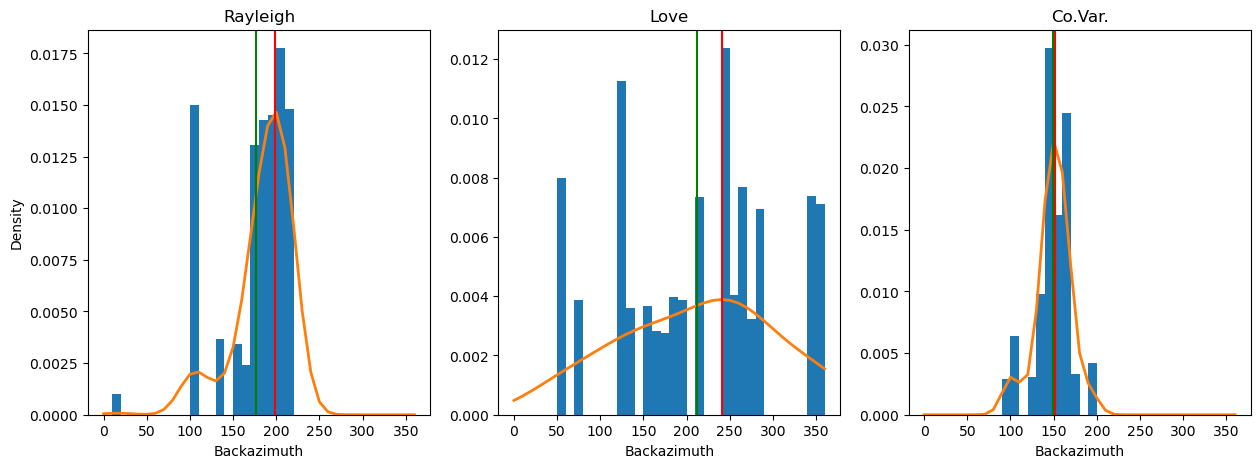

 -> obtained: 5 of 5 stations!

 -> Runtime: 0.29 minutes
 -> obtained: 8 of 8 stations!

 -> Runtime: 0.49 minutes
 -> obtained: 13 of 13 stations!

 -> Runtime: 0.74 minutes
 -> obtained: 8 of 8 stations!

 -> Runtime: 0.48 minutes


In [242]:
stt = st0.copy();

acc = stt.copy().select(station="PFO*");

for tr in stt:
    if "BSPF" in tr.stats.station:
        tr.data = np.roll(tr.data, 3)

cc_thres = 0.2

## ____________________
## direct rotation
rot = stt.copy().select(station="BSPF");
out_bspf_i = __compare_backazimuth_codes(rot, acc, event, 2.0, 5.0, cc_thres=cc_thres, plot=True);

rot = stt.copy().select(station="BSPF");
out_bspf_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 1.0, cc_thres=cc_thres, plot=True);

rot = stt.copy().select(station="BSPF");
out_bspf_a = __compare_backazimuth_codes(rot, acc, event, 0.1, 0.5, cc_thres=cc_thres, plot=True);

rot = stt.copy().select(station="BSPF");
out_bspf_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 1.0, cc_thres=cc_thres, plot=True);

# out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);


## ____________________
## adr rotation
rot = stt.copy().select(station="RPFO", location="in");
out_adr_i = __compare_backazimuth_codes(rot, acc, event, 2.0, 5.0, cc_thres=cc_thres, plot=False);

rot = stt.copy().select(station="RPFO", location="mi");
out_adr_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 1.0, cc_thres=cc_thres, plot=False);

rot = stt.copy().select(station="RPFO", location="al");
out_adr_a = __compare_backazimuth_codes(rot, acc, event, 0.1, 0.5, cc_thres=cc_thres, plot=False);

rot = stt.copy().select(station="RPFO", location="mi");
out_adr_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 1.0, cc_thres=cc_thres, plot=False);

## ____________________
## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=2.0, fmax=5.0, component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=1.0, component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.1, fmax=0.5, component="Z", submask="all", plot=False)
out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=1.0, component="Z", submask="mid", plot=False)


In [243]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF", "BSPF", "ADR", "BF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="yellow", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a, out_adr_o]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a, out_bspf_o]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a, out_bf_o]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4,3,3.2,3.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "2.0 - 5.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 1.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.1 - 0.5 Hz", fontsize=font-1)
    ax.text(3, 360+10, "0.8 - 1.0 Hz", fontsize=font-1)


    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 4.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

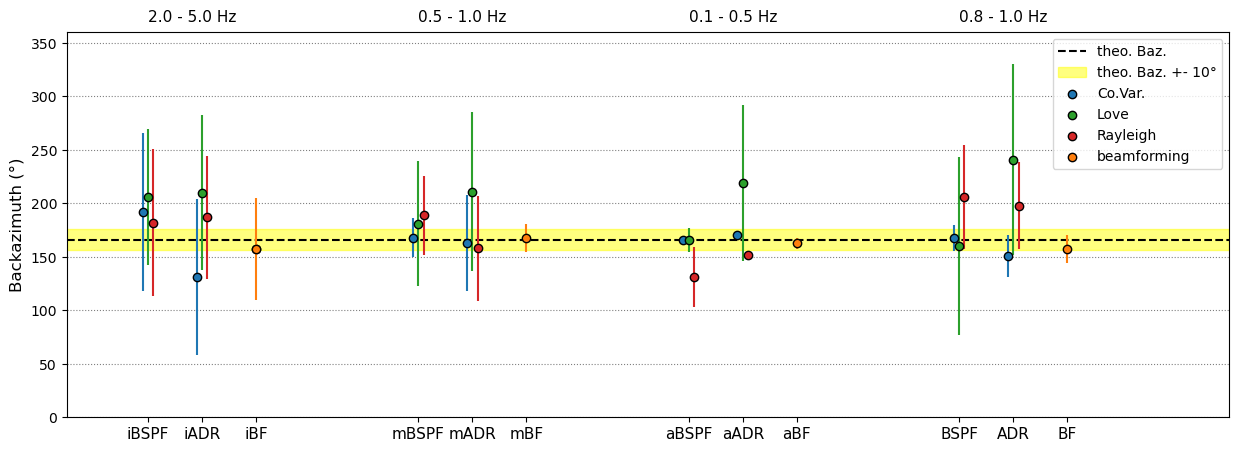

In [244]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Cross Spectral Density

In [ ]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        bspf_inner.normalize()
        
        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        adr_inner.normalize()
        
        nseg = int(5*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data,
                        adr_inner.data,
                        fs=bspf_inner.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='density',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")        
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        adr_all.normalize()        
            
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data*rot_scaling,
                        adr_all.data*rot_scaling,
                        fs=bspf_all.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='spectrum',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:       
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
            

#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
    
    ax7.set_xscale("log")   
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.1, 20)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)
    
    
    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
__makeplotStream_csd2(st0, config);

## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
acc = st0.select(station="PFO*").copy()
# rot = st0.select(station="BSPF").copy()
rot = st0.select(station="RPFO", location="mi").copy()

fmin, fmax = 0.5, 1.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)

rot.trim(rot[0].stats.starttime+10, rot[0].stats.endtime)
acc.trim(acc[0].stats.starttime+10, acc[0].stats.endtime)

# import numpy as np
# for tr in rot:
#     tr.data = np.roll(tr.data, 1)

# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

In [ ]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_love_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_rayleigh_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [ ]:
from functions.get_octave_bands import __get_octave_bands

In [ ]:
def __estimate_velocity_in_fbands():

    flower, fupper, fcenter = __get_octave_bands(0.3, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.3, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        # rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO", location="al").copy();
        # rot = st0.select(station="RPFO", location="mi").copy();
        rot = st0.select(station="RPFO", location="in").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        velo = np.arange(0, 5000, 250)

        cc_threshold = 0.2
        overlap = 0.9

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]
        if len(lvel) > 0:
            hist = np.histogram(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_l['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            love_velo.append(data)
            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")

        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]
        if len(rvel) > 0:
            hist = np.histogram(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_r['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            rayl_velo.append(data)
            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig1, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")


    plt.show();




    fig2, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo

    ax.yaxis.grid(True)
    out2 = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();
    return fig1, fig2


fig1, fig2 = __estimate_velocity_in_fbands()


fig1.savefig(config['path_to_figs']+f"BSFP_M42_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

fig2.savefig(config['path_to_figs']+f"BSFP_M42_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')


## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()